In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# === 1) 构造二维高斯“器官/结节”phantom ===
N = 256
FOV = 1.0                               # 物理场景一半边长（坐标范围 [-FOV, FOV]）
xs = np.linspace(-FOV, FOV, N)
ys = np.linspace(-FOV, FOV, N)
X, Y = np.meshgrid(xs, ys)

In [3]:
def gaussian_blob(x0, y0, sigma, amp=1.0):
    return amp * np.exp(-((X-x0)**2 + (Y-y0)**2) / (2*sigma**2))

phantom = (
    gaussian_blob(-0.35, -0.10, 0.10, 0.9) +
    gaussian_blob( 0.25,  0.15, 0.07, 0.7) +
    gaussian_blob( 0.10, -0.30, 0.05, 1.2) +
    0.2 * gaussian_blob( 0.00,  0.00, 0.35, 1.0)
)

# ---------- 公共：构建以 0 为中心、奇数长度的 t 轴 ----------
def make_t_axis(fov: float, num_det: int) -> np.ndarray:
    """
    生成以 0 为中心的 t 轴（奇数长度时 t=0 正好落在中心像素上）。
    参数:
        fov: 视野半径（[-fov, fov]）
        num_det: 探测器通道数（建议奇数，如 513）
    返回:
        t_axis: np.ndarray, 形如 [-t_max, ..., 0, ..., t_max]
    """
    t_max = np.sqrt(2) * fov
    return np.linspace(-t_max, t_max, num_det, dtype=np.float32)


# ---------- Sinogram 构建（平行束 parallel-beam） ----------
def build_sinogram_parallel(img: np.ndarray,
                            thetas: np.ndarray,
                            t_axis: np.ndarray,
                            fov: float) -> np.ndarray:
    """
    将 2D 图像 f(x,y) 投影到给定的 t 轴上，得到平行束 [sinogram]。

    参数:
        img    : 2D phantom, shape [H, W]
        thetas : 角度数组（弧度），等步长
        t_axis : 探测器坐标（与投影方向正交），必须各路径共用
        fov    : 视野半径（与 make_t_axis 保持一致）

    返回:
        sino: shape [n_angles, len(t_axis)]
    """
    H, W = img.shape
    xs = np.linspace(-fov, fov, W, dtype=np.float32)
    ys = np.linspace(-fov, fov, H, dtype=np.float32)
    XX, YY = np.meshgrid(xs, ys)

    pts   = np.stack([XX.ravel(), YY.ravel()], axis=1)   # [HW, 2]
    fvals = img.ravel().astype(np.float32)

    n_angles = len(thetas)
    n_det    = t_axis.size
    sino = np.zeros((n_angles, n_det), dtype=np.float32)

    # 线性插值地把散点累加到规则 t_axis 上（避免最近邻带来的偏差）
    t0, t1 = t_axis[0], t_axis[-1]
    scale  = (n_det - 1) / (t1 - t0)

    for i, th in enumerate(thetas):
        c, s = np.cos(th), np.sin(th)
        t_coords = pts[:, 0] * c + pts[:, 1] * s        # 所有像素对应的 t

        u  = (t_coords - t0) * scale                    # 连续下标
        u0 = np.floor(u).astype(np.int64)
        du = u - u0

        valid0 = (u0 >= 0) & (u0 < n_det)
        valid1 = (u0 + 1 >= 0) & (u0 + 1 < n_det)

        np.add.at(sino[i], u0[valid0],     fvals[valid0] * (1.0 - du[valid0]))
        np.add.at(sino[i], (u0 + 1)[valid1], fvals[valid1] *        du[valid1])

    return sino


# ---------- 360° → 180° 折叠（消冗余：θ 与 θ+π 配对，t 轴镜像后平均） ----------
def collapse_360_to_180(sino_360: np.ndarray,
                        thetas_360: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    将 0–360° 的平行束 sinogram 折叠为 0–180°：
    利用 p_{θ+π}(t) = p_θ(-t)，对 (θ, θ+π) 配对，将 t 轴镜像后做 0.5*(a + mirror(b))。

    要求:
        - len(thetas_360) 为偶数，且等步长覆盖 [0, 2π)（endpoint=False）

    返回:
        sino_180, thetas_180
    """
    n = sino_360.shape[0]
    assert n % 2 == 0, "360° 投影数应为偶数，便于与 θ+π 配对"
    half = n // 2
    sino_180 = 0.5 * (sino_360[:half] + np.flip(sino_360[half:], axis=1))
    thetas_180 = thetas_360[:half]
    return sino_180, thetas_180


# ---------- Ramp (Ram-Lak) 滤波（频域实现，含零填充） ----------
def ramp_filter(proj: np.ndarray, dt: float, pad: bool = True) -> np.ndarray:
    """
    对每条投影沿 t 方向做 Ramp（Ram-Lak）滤波。
    参数:
        proj: [n_angles, n_det]
        dt  : t 轴采样间隔
        pad : 是否做零填充以减小循环卷积效应（推荐 True）
    返回:
        proj_filtered: [n_angles, n_det]
    """
    n_angles, n_det = proj.shape
    n_pad = int(2 ** np.ceil(np.log2(n_det * 2))) if pad else n_det
    freqs = np.fft.fftfreq(n_pad, d=dt).astype(np.float32)
    ramp  = np.abs(freqs)

    out = np.empty_like(proj, dtype=np.float32)
    for i in range(n_angles):
        F  = np.fft.fft(proj[i], n=n_pad)
        Ff = F * ramp
        f  = np.fft.ifft(Ff).real[:n_det]
        out[i] = f.astype(np.float32)
    return out



# === 2) 基于解析式生成 Radon 投影（sinogram） ===
# 对 2D 高斯 f(x,y)=exp(-((x-x0)^2+(y-y0)^2)/(2σ^2))，沿直线 x cosθ + y sinθ = t 的积分
# pθ(t) = √(2π) σ * exp(-(t - (x0 cosθ + y0 sinθ))^2 / (2σ^2)) * amp
# 我们把 phantom 分解为若干高斯之和（上面已构造），并用数值“采样”来生成 sinogram。
# 为简单起见，我们直接从 phantom 样本点近似，也等价于离散卷积近似。
def build_sinogram_from_samples(img, thetas, num_det=512, t_max=None):
    """
    简单/高效数值法：对每个角度，把 (x,y) 上的 f(x,y) 沿 t = x cosθ + y sinθ 累加到检测器 bins。
    """
    H, W = img.shape
    # 采样坐标与权重
    xs = np.linspace(-FOV, FOV, W)
    ys = np.linspace(-FOV, FOV, H)
    XX, YY = np.meshgrid(xs, ys)
    vals = img

    # t 轴范围
    if t_max is None:
        t_max = np.sqrt((FOV**2) + (FOV**2))  # 对角线的一半（半径）
    ts = np.linspace(-t_max, t_max, num_det)

    sino = np.zeros((len(thetas), num_det), dtype=np.float32)

    # 展平便于矢量化
    pts = np.stack([XX.ravel(), YY.ravel()], axis=1)
    fvals = vals.ravel()

    for i, th in enumerate(thetas):
        c, s = np.cos(th), np.sin(th)
        t_coords = pts[:,0]*c + pts[:,1]*s   # 所有点投影到该角度的 t 值
        # 把离散点“撒”到 ts 上（最近邻 / 线性插值）；这里用直方图方式聚合
        # 为更平滑，可换成线性插值；此处采用加速版直方图累加。
        # 归一化到 [0, num_det-1]
        idx = np.clip(((t_coords - ts[0]) / (ts[-1]-ts[0]) * (num_det-1)).astype(int), 0, num_det-1)
        # 累加（像素值作为权重）
        np.add.at(sino[i], idx, fvals)
    return ts, sino

# 角度设置
angles_180 = np.linspace(0, np.pi, 360, endpoint=False)   # 0-180°
angles_90 = np.linspace(0, np.pi/2, 180, endpoint=False) # 0-90°

t_axis, sino_full = build_sinogram_from_samples(phantom, angles_180, num_det=512)
_,      sino_half = build_sinogram_from_samples(phantom, angles_90, num_det=512)

# === 3) FBP：对 sinogram 逐角度滤波(Ram-Lak) + 反投影 ===
# def ramp_filter(proj):
#     """对每条投影（沿 t 方向）施加 Ram-Lak 滤波（频域乘 |ω|）。"""
#     n = proj.shape[-1]
#     freqs = np.fft.fftfreq(n, d=(t_axis[1]-t_axis[0]))
#     ramp = np.abs(freqs)
#     # FFT -> 乘 |ω| -> IFFT
#     F = np.fft.fft(proj, axis=-1)
#     F_filtered = F * ramp
#     return np.real(np.fft.ifft(F_filtered, axis=-1))

def fbp_reconstruct(
    sinogram,
    thetas,
    img_size=N,
    geometry="parallel",              # 这里只处理平行束；扇束/锥束需 Parker 权重
    redundancy="collapse"             # {"collapse", "halfweight", "none"}
):
    H = W = img_size
    xs = np.linspace(-FOV, FOV, W)
    ys = np.linspace(-FOV, FOV, H)
    XX, YY = np.meshgrid(xs, ys)
    rec = np.zeros((H, W), dtype=np.float32)

    # --- 1) 若是 0–360° 且平行束，先处理冗余 ---
    sino_use = sinogram
    th_use   = thetas

    full_circle = (thetas.max() - thetas.min()) > (np.pi + 1e-6)  # 粗判是否超过半圈
    if geometry == "parallel" and full_circle:
        if redundancy == "collapse":
            # 按 θ 与 θ+π 配对，t 轴取反后平均 -> 折叠为半圈
            half = sinogram.shape[0] // 2
            assert sinogram.shape[0] % 2 == 0, "0–360° 情况请使用偶数投影数便于配对"
            sino_use = 0.5 * (sinogram[:half] + np.flip(sinogram[half:half*2], axis=1))
            th_use   = thetas[:half]  # 变为 0–180°
        elif redundancy == "halfweight":
            # 保留整圈，但对每个角乘 0.5；归一化按“非冗余角数”计算
            pass
        elif redundancy == "none":
            # 不做处理：会“加两遍”信息，结果会与 0–180° 不同
            pass

    # --- 2) 滤波（Ram-Lak） ---
    sino_f = ramp_filter(sino_use)

    # --- 3) 反投影积分 ---
    # 假设角度等步长
    dtheta = (th_use[1] - th_use[0]) if len(th_use) > 1 else np.pi

    # halfweight 情况下：每个角的权重 = 0.5 * dtheta；否则 = dtheta
    per_angle_weight = (0.5 * dtheta) if (geometry == "parallel" and full_circle and redundancy == "halfweight") else dtheta

    for i, th in enumerate(th_use):
        c, s = np.cos(th), np.sin(th)
        t_xy = XX * c + YY * s
        proj_i = np.interp(t_xy, t_axis, sino_f[i], left=0.0, right=0.0)
        rec += proj_i * per_angle_weight   # 数值积分

    # --- 4) 归一化 ---
    # 归一化按“非冗余角数”计算：半圈对应 π。
    if geometry == "parallel":
        if full_circle and redundancy in ("collapse", "halfweight"):
            nonredundant_len = len(th_use) if redundancy == "collapse" else (len(th_use) // 2)
        else:
            nonredundant_len = len(th_use)
        # 与原版保持风格一致：尺度到大致[0,1]
        rec = rec * (np.pi / max(nonredundant_len, 1))
    else:
        # 扇束/锥束：此处仅占位；实际应使用 Parker weighting 或相应几何校正
        rec = rec * (np.pi / max(len(th_use), 1))

    rec = rec / (np.max(rec) + 1e-8)
    return rec



def fbp_reconstruct_parallel(sinogram: np.ndarray,
                             thetas: np.ndarray,
                             t_axis: np.ndarray,
                             fov: float,
                             img_size: int) -> np.ndarray:
    """
    平行束 [FBP]：对 sinogram 先 Ramp 滤波、再按角度积分反投影。
    - 归一化按“半圈 = π”的尺度（即 ∫_0^π），不做每幅图各自的 max 归一化，
      避免亮度/对比度引入非线性差异，保证 180° 与折叠后的 360° 可比。
    """
    H = W = img_size
    xs = np.linspace(-fov, fov, W, dtype=np.float32)
    ys = np.linspace(-fov, fov, H, dtype=np.float32)
    XX, YY = np.meshgrid(xs, ys)

    dt = t_axis[1] - t_axis[0]
    sino_f = ramp_filter(sinogram, dt=dt, pad=True)

    if len(thetas) > 1:
        dtheta = thetas[1] - thetas[0]
    else:
        dtheta = np.pi

    # 反投影积分（线性插值采样）
    rec = np.zeros((H, W), dtype=np.float32)
    n_det = t_axis.size
    t0, t1 = t_axis[0], t_axis[-1]
    scale  = (n_det - 1) / (t1 - t0)

    for i, th in enumerate(thetas):
        c, s = np.cos(th), np.sin(th)
        t_xy = XX * c + YY * s
        u  = (t_xy - t0) * scale
        u0 = np.floor(u).astype(np.int64)
        du = u - u0

        valid0 = (u0 >= 0) & (u0 < n_det)
        valid1 = (u0 + 1 >= 0) & (u0 + 1 < n_det)

        proj = np.zeros_like(t_xy, dtype=np.float32)
        p = sino_f[i]
        proj[valid0] += p[u0[valid0]] * (1.0 - du[valid0])
        proj[valid1] += p[(u0 + 1)[valid1]] *        du[valid1]

        rec += proj * dtheta

    # 统一线性归一化：按“半圈 = π”的角度尺度
    rec *= (1.0 / np.pi)
    return rec


In [4]:
FOV = 1.0
num_det = 513
t_axis = make_t_axis(FOV, num_det)

angles_90  = np.linspace(0, np.pi/2, 180, endpoint=False)   # 0–90°
angles_180 = np.linspace(0, np.pi,   360, endpoint=False)   # 0–180°
angles_360 = np.linspace(0, 2*np.pi, 720, endpoint=False)   # 0–360°（先生成，后折叠）

sino_90  = build_sinogram_parallel(phantom, angles_90,  t_axis, FOV)
sino_180 = build_sinogram_parallel(phantom, angles_180, t_axis, FOV)
sino_360 = build_sinogram_parallel(phantom, angles_360, t_axis, FOV)
sino_360c, angles_360c = collapse_360_to_180(sino_360, angles_360)  # 折叠为半圈

In [5]:
rec_90   = fbp_reconstruct_parallel(sino_90,   angles_90,   t_axis, FOV, N)
rec_180  = fbp_reconstruct_parallel(sino_180,  angles_180,  t_axis, FOV, N)
rec_360c = fbp_reconstruct_parallel(sino_360c, angles_360c, t_axis, FOV, N)

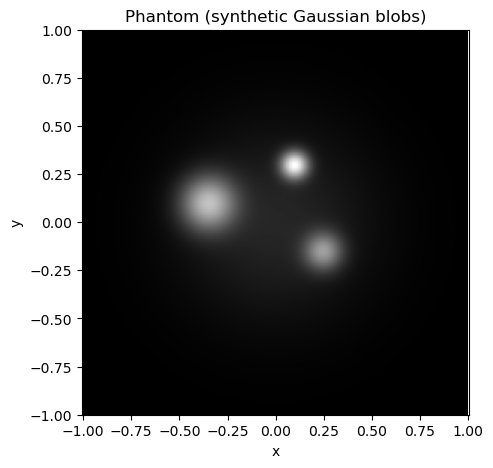

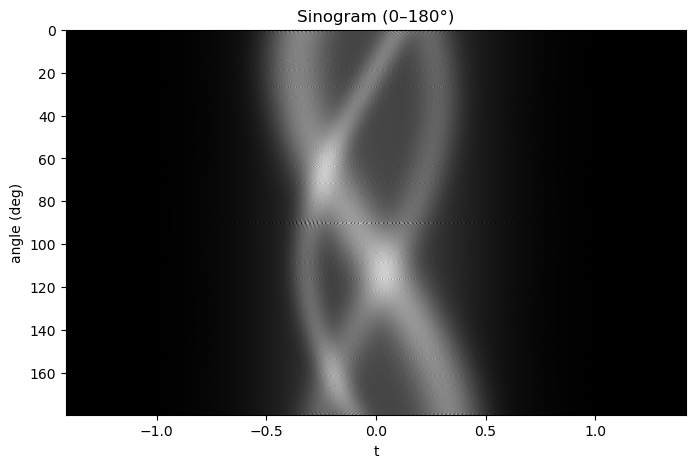

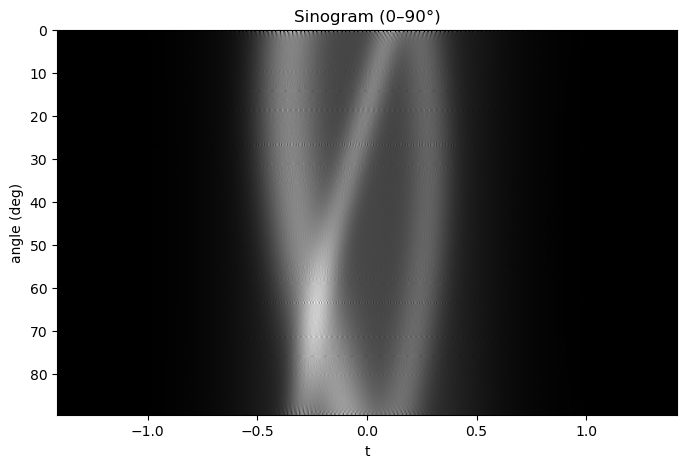

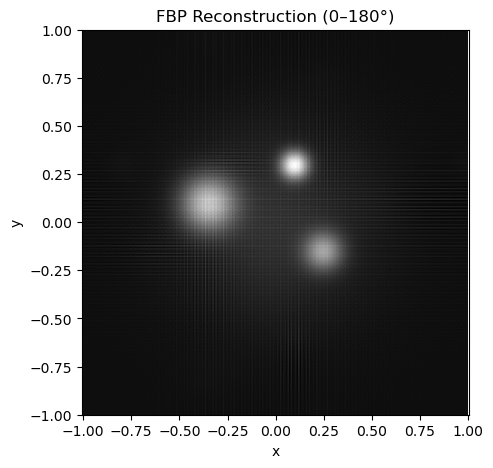

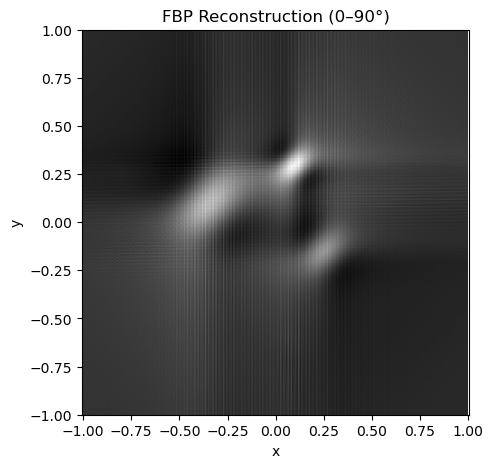

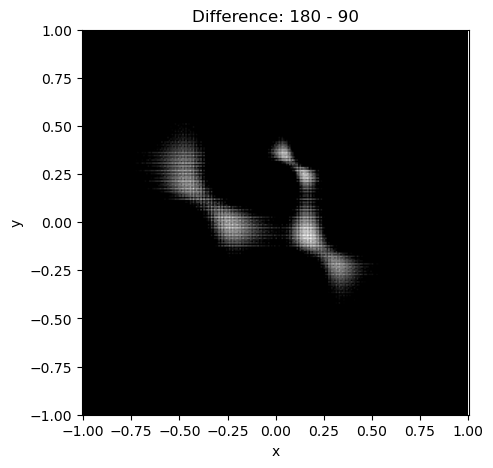

In [11]:
# 4.1 Phantom
plt.figure(figsize=(5,5))
plt.imshow(phantom, cmap='gray', extent=[-FOV, FOV, -FOV, FOV])
plt.title("Phantom (synthetic Gaussian blobs)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis('equal'); plt.show()

# 4.2 Sinogram (0-180° 与 0-90°)
plt.figure(figsize=(8,5))
plt.imshow(sino_full, aspect='auto', cmap='gray',
           extent=[t_axis[0], t_axis[-1], angles_180[-1]*180/np.pi, angles_180[0]*180/np.pi])
plt.title("Sinogram (0–180°)")
plt.xlabel("t"); plt.ylabel("angle (deg)")
plt.show()

plt.figure(figsize=(8,5))
plt.imshow(sino_half, aspect='auto', cmap='gray',
           extent=[t_axis[0], t_axis[-1], angles_90[-1]*180/np.pi, angles_90[0]*180/np.pi])
plt.title("Sinogram (0–90°)")
plt.xlabel("t"); plt.ylabel("angle (deg)")
plt.show()

# 4.3 重建对比
plt.figure(figsize=(5,5))
plt.imshow(rec_180, cmap='gray', extent=[-FOV, FOV, -FOV, FOV])
plt.title("FBP Reconstruction (0–180°)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis('equal'); plt.show()

plt.figure(figsize=(5,5))
plt.imshow(rec_90, cmap='gray', extent=[-FOV, FOV, -FOV, FOV])
plt.title("FBP Reconstruction (0–90°)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis('equal'); plt.show()

# 4.4 差异图
diff = np.clip(rec_180 - rec_90, 0, None)
plt.figure(figsize=(5,5))
plt.imshow(diff / (diff.max() + 1e-6), cmap='gray', extent=[-FOV, FOV, -FOV, FOV])
plt.title("Difference: 180 - 90")
plt.xlabel("x"); plt.ylabel("y")
plt.axis('equal'); plt.show()

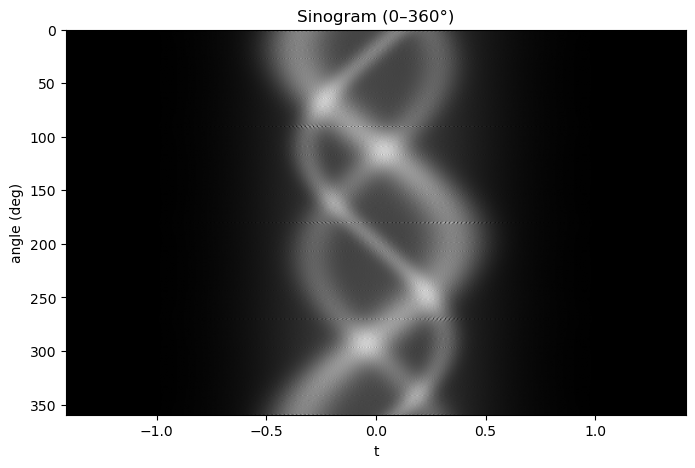

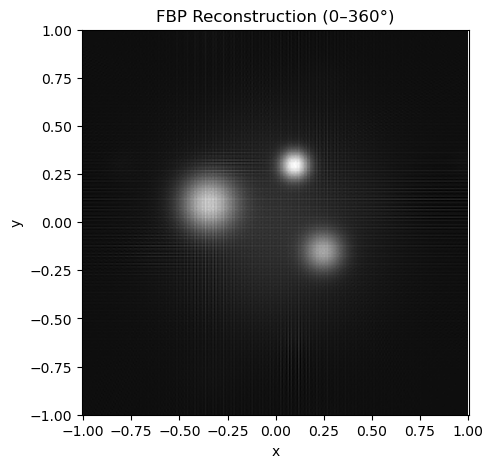

In [8]:
# === 额外画 0-360° 的 FBP 重建对比 ===

angles_360 = np.linspace(0, 2*np.pi, 720, endpoint=False)
_, sino_360 = build_sinogram_from_samples(phantom, angles_360, num_det=512)

# 折叠冗余：θ 与 θ+π 配对，t 轴取反后平均
half = sino_360.shape[0] // 2  # 360°的一半 = 180°
sino_360_collapsed = 0.5 * (sino_360[:half] + np.flip(sino_360[half:], axis=1))

angles_180 = np.linspace(0, np.pi, half, endpoint=False)
rec_360 = fbp_reconstruct_parallel(sino_360c, angles_360c, t_axis, FOV, N)

# 可视化
plt.figure(figsize=(8,5))
plt.imshow(sino_360, aspect='auto', cmap='gray',
           extent=[t_axis[0], t_axis[-1], angles_360[-1]*180/np.pi, angles_360[0]*180/np.pi])
plt.title("Sinogram (0–360°)")
plt.xlabel("t"); plt.ylabel("angle (deg)")
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(rec_360, cmap='gray', extent=[-FOV, FOV, -FOV, FOV])
plt.title("FBP Reconstruction (0–360°)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis('equal'); plt.show()


In [9]:
import numpy as np
import pandas as pd

def normalize01(img):
    img = img.astype(np.float32)
    m, M = img.min(), img.max()
    if M - m < 1e-8:
        return np.zeros_like(img, dtype=np.float32)
    return (img - m) / (M - m)

def ssim_global(x, y, C1=0.01**2, C2=0.03**2):
    """
    计算全图 [SSIM]（不使用滑动窗口版本）。
    x, y 应该为 [0,1] 范围的 float32 图像。
    """
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    mx = np.mean(x)
    my = np.mean(y)
    vx = np.var(x, ddof=1)
    vy = np.var(y, ddof=1)
    cxy = np.mean((x - mx) * (y - my))
    num = (2*mx*my + C1) * (2*cxy + C2)
    den = (mx*mx + my*my + C1) * (vx + vy + C2)
    return float(num / (den + 1e-12))

# 归一化到 [0,1]
ph = normalize01(phantom)
rec_90  = normalize01(rec_90)
rec_180 = normalize01(rec_180)
rec_360 = normalize01(rec_360)

# 计算全图 SSIM
rows = []
rows.append(["0–90° vs orginal",  ssim_global(ph, rec_90)])
rows.append(["0–180° vs orginal", ssim_global(ph, rec_180)])
rows.append(["0–360° vs orginal", ssim_global(ph, rec_360)])

df = pd.DataFrame(rows, columns=["", "SSIM"])

df


,,SSIM
0,0–90° vs orginal,0.296961
1,0–180° vs orginal,0.732185
2,0–360° vs orginal,0.732187
